In [1]:
from fastkan import FastKAN as KAN

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

import torchtext
torchtext.disable_torchtext_deprecation_warning()

from torchtext.datasets import IMDB
from transformers import GPT2Tokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kaloq\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data = pd.read_csv('./imdb.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
def transform_label(label):
    return 1 if label == 'positive' else 0

data['label'] = data['sentiment'].progress_apply(transform_label)
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 1078781.89it/s]


,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [5]:
data.sentiment.value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [6]:
data['token_length'] = data.review.progress_apply(lambda x: len(x.split()))
data.head()

100%|██████████| 50000/50000 [00:00<00:00, 109317.65it/s]


,review,sentiment,label,token_length
0,One of the other reviewers has mentioned that ...,positive,1,307
1,A wonderful little production. <br /><br />The...,positive,1,162
2,I thought this was a wonderful way to spend ti...,positive,1,166
3,Basically there's a family where a little boy ...,negative,0,138
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230


In [7]:
data_pos = data[data['label'] == 1]
print("Positive review length")
data_pos['token_length'].describe()

Positive review length


count    25000.000000
mean       232.849320
std        177.497046
min         10.000000
25%        125.000000
50%        172.000000
75%        284.000000
max       2470.000000
Name: token_length, dtype: float64

In [8]:
data_neg = data[data['label'] == 0]
print("Negative review length")
data_neg['token_length'].describe()

Negative review length


count    25000.000000
mean       229.464560
std        164.947795
min          4.000000
25%        128.000000
50%        174.000000
75%        278.000000
max       1522.000000
Name: token_length, dtype: float64

In [9]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 
    words = word_tokenize(text)
    sent = [word for word in words if word not in stop_words]
    sent = ' '.join(sent)
    
    return sent

In [10]:
# Apply the preprocessing to the 'review' column (assuming the column name is 'review')
data['clean'] = data.review.progress_apply(preprocess_text)

# Display the first few rows of the dataframe with the cleaned reviews
data.head()

100%|██████████| 50000/50000 [00:24<00:00, 2070.12it/s]


,review,sentiment,label,token_length,clean
0,One of the other reviewers has mentioned that ...,positive,1,307,one reviewers mentioned watching 1 oz episode ...
1,A wonderful little production. <br /><br />The...,positive,1,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,166,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,138,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,230,petter mattei love time money visually stunnin...


In [11]:
pd.set_option('display.max_colwidth', 200)
display(data[['review', 'clean']])

,review,clean
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...",one reviewers mentioned watching 1 oz episode hooked right exactly happened first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls ...
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...",wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got pol...
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...",thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial...
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenl...,basically family little boy jake thinks zombie closet parents fighting time movie slower soap opera suddenly jake decides become rambo kill zombie ok first going make film must decide thriller dra...
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what mone...",petter mattei love time money visually stunning film watch mr mattei offers us vivid portrait human relations movie seems telling us money power success people different situations encounter varia...
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lotta fun. the more i think about it the more i like ...",thought movie right good job creative original first expecting whole lotta fun think like comes dvd going pay money proudly every last cent sharon stone great always even movie horrible catwoman m...
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a crappy copy of the VHS cannot be redeemed by consum...",bad plot bad dialogue bad acting idiotic directing annoying porn groove soundtrack ran continually overacted script crappy copy vhs redeemed consuming liquor trust stuck turkey end pathetically ba...
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholic but would not be considered a ""good Catholic"" in...",catholic taught parochial elementary schools nuns taught jesuit priests high school college still practicing catholic would considered good catholic church eyes believe certain things act certain ...
49998,"I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second rate, excessively vicious Western that creaks and groans trying to put across its central...",going disagree previous comment side maltin one second rate excessively vicious western creaks groans trying put across central theme wild west tamed kicked aside steady march time would like trad...


In [12]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [13]:
tokenizer.pad_token = tokenizer.eos_token
max_l = 250
data['tokenized'] = data.clean.progress_apply(lambda x: tokenizer.encode(text=x, add_special_tokens=False, truncation=True, add_prefix_space=True, padding='max_length', max_length=max_l))

100%|██████████| 50000/50000 [00:32<00:00, 1557.34it/s]


In [14]:
data.head

<bound method NDFrame.head of                                                                                                                                                                                                         review  \
0      One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me...   
1      A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire p...   
2      I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue i...   
3      Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all t

In [15]:
data['ct_length'] = data.tokenized.progress_apply(lambda x: len(x))
data_pos = data[data['label'] == 1]
data_pos['ct_length'].describe()

100%|██████████| 50000/50000 [00:00<00:00, 1348624.79it/s]


count    25000.0
mean       250.0
std          0.0
min        250.0
25%        250.0
50%        250.0
75%        250.0
max        250.0
Name: ct_length, dtype: float64

In [16]:
from torch.utils.data import DataLoader, TensorDataset

X = data.tokenized
y = data.label

# Use train_test_split to split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=39)

# Convert to PyTorch tensors
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.tolist()).to(device)
X_test_tensor = torch.tensor(X_test.tolist()).to(device)
y_train_tensor = torch.tensor(y_train.tolist()).to(device)
y_test_tensor = torch.tensor(y_test.tolist()).to(device)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [17]:
# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from fastkan import FastKAN as KAN

import torch
import torch.nn as nn
import torch.nn.functional as F

class SentimentCNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(SentimentCNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Define convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(1, 300, (1, embed_dim), padding=(0, 0))  # 1-gram
        self.bn1 = nn.BatchNorm2d(300)
        
        self.conv2 = nn.Conv2d(1, 300, (3, embed_dim), padding=(1, 0))  # 3-gram
        self.bn2 = nn.BatchNorm2d(300)
        
        self.conv3 = nn.Conv2d(1, 300, (5, embed_dim), padding=(2, 0))  # 5-gram
        self.bn3 = nn.BatchNorm2d(300)
        
        self.dropout = nn.Dropout(0.5)
        # Replace dense layers with FastKAN
        self.kan = KAN([112500, 1024, 256, 128, 64, num_class], num_grids=4)

    def forward(self, text):
        embedded = self.embedding(text).unsqueeze(1)  # Add channel dimension
        
        conv1_out = F.relu(self.bn1(self.conv1(embedded))).squeeze(3)
        conv2_out = F.relu(self.bn2(self.conv2(embedded))).squeeze(3)
        conv3_out = F.relu(self.bn3(self.conv3(embedded))).squeeze(3)
        
        pooled1 = F.max_pool1d(conv1_out, 2).squeeze(2)
        pooled2 = F.max_pool1d(conv2_out, 2).squeeze(2)
        pooled3 = F.max_pool1d(conv3_out, 2).squeeze(2)

        cat = torch.cat((pooled1, pooled2, pooled3), 1)
        cat = cat.view(cat.size(0), -1)
        cat = self.dropout(cat)
        
        # Use FastKAN for final classification
        out = self.kan(cat)
        return out


# Instantiate the model
vocab_size = len(tokenizer)  # Vocabulary size of GPT-2 tokenizer
embed_dim = 128  # Embedding dimension
num_class = 2  # Number of classes (negative, positive)

model = SentimentCNNModel(vocab_size, embed_dim, num_class)
model.to(device)

SentimentCNNModel(
  (embedding): Embedding(50257, 128)
  (conv1): Conv2d(1, 300, kernel_size=(1, 128), stride=(1, 1))
  (bn1): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(1, 300, kernel_size=(3, 128), stride=(1, 1), padding=(1, 0))
  (bn2): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(1, 300, kernel_size=(5, 128), stride=(1, 1), padding=(2, 0))
  (bn3): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (kan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((112500,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=450000, out_features=1024, bias=False)
        (base_linear): Linear(in_features=112500, out_features=1024, bias=True)
      )
      (1): FastKANLayer(
        (layernorm): Lay

In [19]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += calculate_accuracy(outputs, labels)
            total += labels.size(0)
    accuracy = correct / total
    avg_loss = total_loss / total
    return accuracy, avg_loss

In [20]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define the accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop with loss and accuracy display
num_epochs = 20
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/20: 100%|██████████| 625/625 [01:45<00:00,  5.90it/s, accuracy=0.51, loss=0.0155] 


Epoch 1, Loss: 0.9907504256248474, Accuracy: 0.509775
Val_Loss: 0.011181396573781968, Val_Accuracy: 0.4961


Epoch 2/20: 100%|██████████| 625/625 [01:45<00:00,  5.90it/s, accuracy=0.744, loss=0.00763]


Epoch 2, Loss: 0.48837346625328065, Accuracy: 0.743975
Val_Loss: 0.005734950068593025, Val_Accuracy: 0.8297


Epoch 3/20: 100%|██████████| 625/625 [02:13<00:00,  4.69it/s, accuracy=0.888, loss=0.00426]


Epoch 3, Loss: 0.27263424919843676, Accuracy: 0.887625
Val_Loss: 0.00451855690330267, Val_Accuracy: 0.8788


Epoch 4/20: 100%|██████████| 625/625 [02:25<00:00,  4.31it/s, accuracy=0.915, loss=0.0034] 


Epoch 4, Loss: 0.21736149419546127, Accuracy: 0.91475
Val_Loss: 0.004859371043741703, Val_Accuracy: 0.8777


Epoch 5/20: 100%|██████████| 625/625 [02:24<00:00,  4.32it/s, accuracy=0.933, loss=0.0028] 


Epoch 5, Loss: 0.17902663116455078, Accuracy: 0.9326
Val_Loss: 0.004525644218176603, Val_Accuracy: 0.8862


Epoch 6/20: 100%|██████████| 625/625 [02:25<00:00,  4.29it/s, accuracy=0.945, loss=0.0023] 


Epoch 6, Loss: 0.14705977827310562, Accuracy: 0.945225
Val_Loss: 0.00566651858612895, Val_Accuracy: 0.8731


Epoch 7/20: 100%|██████████| 625/625 [02:03<00:00,  5.06it/s, accuracy=0.957, loss=0.00185]


Epoch 7, Loss: 0.11809774144887925, Accuracy: 0.957375
Val_Loss: 0.005015717773884535, Val_Accuracy: 0.8867


Epoch 8/20: 100%|██████████| 625/625 [01:44<00:00,  5.95it/s, accuracy=0.968, loss=0.00142]


Epoch 8, Loss: 0.09084228325784206, Accuracy: 0.9681
Val_Loss: 0.007167516019940376, Val_Accuracy: 0.8711


Epoch 9/20: 100%|██████████| 625/625 [01:44<00:00,  5.99it/s, accuracy=0.976, loss=0.00116]


Epoch 9, Loss: 0.0744145672634244, Accuracy: 0.9755
Val_Loss: 0.006045880229026079, Val_Accuracy: 0.8858


Epoch 10/20: 100%|██████████| 625/625 [01:43<00:00,  6.02it/s, accuracy=0.983, loss=0.00081] 


Epoch 10, Loss: 0.051871807634085415, Accuracy: 0.9833
Val_Loss: 0.007188316638022661, Val_Accuracy: 0.8744


Epoch 11/20: 100%|██████████| 625/625 [02:06<00:00,  4.93it/s, accuracy=0.987, loss=0.000665]


Epoch 11, Loss: 0.04253309460449964, Accuracy: 0.986875
Val_Loss: 0.006843431936949492, Val_Accuracy: 0.8856


Epoch 12/20: 100%|██████████| 625/625 [02:15<00:00,  4.61it/s, accuracy=0.99, loss=0.000543] 


Epoch 12, Loss: 0.034776715072058144, Accuracy: 0.989875
Val_Loss: 0.007559985507279634, Val_Accuracy: 0.8838


Epoch 13/20: 100%|██████████| 625/625 [02:15<00:00,  4.63it/s, accuracy=0.992, loss=0.000431]


Epoch 13, Loss: 0.027591142519563436, Accuracy: 0.992375
Val_Loss: 0.008263573347777128, Val_Accuracy: 0.8844


Epoch 14/20: 100%|██████████| 625/625 [01:57<00:00,  5.30it/s, accuracy=0.994, loss=0.000369]


Epoch 14, Loss: 0.02360853800699115, Accuracy: 0.993575
Val_Loss: 0.00895414869338274, Val_Accuracy: 0.8831


Epoch 15/20: 100%|██████████| 625/625 [02:14<00:00,  4.64it/s, accuracy=0.995, loss=0.000323]


Epoch 15, Loss: 0.020669522936828433, Accuracy: 0.994525
Val_Loss: 0.008418195082247257, Val_Accuracy: 0.8795


Epoch 16/20: 100%|██████████| 625/625 [01:51<00:00,  5.59it/s, accuracy=0.995, loss=0.000285]


Epoch 16, Loss: 0.018257920158375053, Accuracy: 0.995075
Val_Loss: 0.009095521327853203, Val_Accuracy: 0.8801


Epoch 17/20: 100%|██████████| 625/625 [01:43<00:00,  6.04it/s, accuracy=0.996, loss=0.000249]


Epoch 17, Loss: 0.015965720500051975, Accuracy: 0.9956
Val_Loss: 0.009657216538488864, Val_Accuracy: 0.8833


Epoch 18/20: 100%|██████████| 625/625 [01:54<00:00,  5.46it/s, accuracy=0.996, loss=0.000222]


Epoch 18, Loss: 0.0142296920100227, Accuracy: 0.996025
Val_Loss: 0.009999549593031407, Val_Accuracy: 0.8824


Epoch 19/20: 100%|██████████| 625/625 [02:02<00:00,  5.12it/s, accuracy=0.997, loss=0.000195]


Epoch 19, Loss: 0.012468960831779986, Accuracy: 0.996675
Val_Loss: 0.010272266270220279, Val_Accuracy: 0.8825


Epoch 20/20: 100%|██████████| 625/625 [01:46<00:00,  5.88it/s, accuracy=0.997, loss=0.000184]


Epoch 20, Loss: 0.011772282336326316, Accuracy: 0.996675
Val_Loss: 0.009855257052183151, Val_Accuracy: 0.8832


In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define the accuracy calculation
def calculate_accuracy(preds, labels):
    _, predicted = torch.max(preds, 1)
    correct = (predicted == labels).sum().item()
    return correct

# Training loop with loss and accuracy display
num_epochs = 20
model_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for texts, labels in pbar:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct_predictions += calculate_accuracy(outputs, labels)
            total_predictions += labels.size(0)
            
            accuracy = correct_predictions / total_predictions
            
            pbar.set_postfix(loss=total_loss/total_predictions, accuracy=accuracy)
    scheduler.step()

    model_history.append(evaluate(model, test_loader))
    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}, Accuracy: {accuracy}')
    print(f'Val_Loss: {model_history[epoch][1]}, Val_Accuracy: {model_history[epoch][0]}')


Epoch 1/20: 100%|██████████| 625/625 [00:23<00:00, 26.88it/s, accuracy=0.505, loss=0.0118]


Epoch 1, Loss: 0.7572059420585633, Accuracy: 0.504725
Val_Loss: 0.010528221219778061, Val_Accuracy: 0.6422


Epoch 2/20: 100%|██████████| 625/625 [00:23<00:00, 27.00it/s, accuracy=0.788, loss=0.00685]


Epoch 2, Loss: 0.43857584884166717, Accuracy: 0.788325
Val_Loss: 0.005096059867739678, Val_Accuracy: 0.8622


Epoch 3/20: 100%|██████████| 625/625 [00:23<00:00, 26.83it/s, accuracy=0.89, loss=0.00419] 


Epoch 3, Loss: 0.2681223642349243, Accuracy: 0.8902
Val_Loss: 0.00460796136111021, Val_Accuracy: 0.8786


Epoch 4/20: 100%|██████████| 625/625 [00:23<00:00, 26.84it/s, accuracy=0.918, loss=0.00324]


Epoch 4, Loss: 0.20738437489271164, Accuracy: 0.9183
Val_Loss: 0.004834065914899111, Val_Accuracy: 0.8779


Epoch 5/20: 100%|██████████| 625/625 [00:23<00:00, 26.81it/s, accuracy=0.936, loss=0.00267]


Epoch 5, Loss: 0.1709580013692379, Accuracy: 0.936025
Val_Loss: 0.0046669319003820415, Val_Accuracy: 0.8805


Epoch 6/20: 100%|██████████| 625/625 [00:23<00:00, 26.64it/s, accuracy=0.947, loss=0.00225]


Epoch 6, Loss: 0.14426176937222482, Accuracy: 0.9465
Val_Loss: 0.004894560081511736, Val_Accuracy: 0.8829


Epoch 7/20: 100%|██████████| 625/625 [00:23<00:00, 26.51it/s, accuracy=0.958, loss=0.00181]


Epoch 7, Loss: 0.11564895841926336, Accuracy: 0.958075
Val_Loss: 0.005312343317270279, Val_Accuracy: 0.8842


Epoch 8/20: 100%|██████████| 625/625 [00:23<00:00, 26.61it/s, accuracy=0.967, loss=0.0015] 


Epoch 8, Loss: 0.09587810815125704, Accuracy: 0.9671
Val_Loss: 0.0056448297537863255, Val_Accuracy: 0.8853


Epoch 9/20: 100%|██████████| 625/625 [00:23<00:00, 26.66it/s, accuracy=0.974, loss=0.00122]


Epoch 9, Loss: 0.07803125004544854, Accuracy: 0.973675
Val_Loss: 0.005967239201068878, Val_Accuracy: 0.8841


Epoch 10/20: 100%|██████████| 625/625 [00:23<00:00, 26.41it/s, accuracy=0.979, loss=0.00106]


Epoch 10, Loss: 0.06768790330588817, Accuracy: 0.978525
Val_Loss: 0.0062370037794113155, Val_Accuracy: 0.885


Epoch 11/20: 100%|██████████| 625/625 [00:23<00:00, 26.70it/s, accuracy=0.983, loss=0.000868]


Epoch 11, Loss: 0.05553557019457221, Accuracy: 0.98265
Val_Loss: 0.006522758761048317, Val_Accuracy: 0.8833


Epoch 12/20: 100%|██████████| 625/625 [00:23<00:00, 26.62it/s, accuracy=0.985, loss=0.000758]


Epoch 12, Loss: 0.0484909176889807, Accuracy: 0.984875
Val_Loss: 0.006375493091344833, Val_Accuracy: 0.8866


Epoch 13/20: 100%|██████████| 625/625 [00:23<00:00, 26.64it/s, accuracy=0.988, loss=0.000634]


Epoch 13, Loss: 0.04057445126399398, Accuracy: 0.987975
Val_Loss: 0.007816014416515827, Val_Accuracy: 0.8835


Epoch 14/20: 100%|██████████| 625/625 [00:23<00:00, 26.74it/s, accuracy=0.988, loss=0.00063] 


Epoch 14, Loss: 0.04028938362635672, Accuracy: 0.987725
Val_Loss: 0.007523023754358291, Val_Accuracy: 0.8851


Epoch 15/20: 100%|██████████| 625/625 [00:23<00:00, 26.63it/s, accuracy=0.989, loss=0.000567]


Epoch 15, Loss: 0.03629569263216108, Accuracy: 0.989325
Val_Loss: 0.007836359308660031, Val_Accuracy: 0.8862


Epoch 16/20: 100%|██████████| 625/625 [00:23<00:00, 26.68it/s, accuracy=0.991, loss=0.000499]


Epoch 16, Loss: 0.031944068809598686, Accuracy: 0.991
Val_Loss: 0.008084721550345422, Val_Accuracy: 0.8867


Epoch 17/20: 100%|██████████| 625/625 [00:23<00:00, 26.15it/s, accuracy=0.992, loss=0.000452]


Epoch 17, Loss: 0.02891103952471167, Accuracy: 0.991625
Val_Loss: 0.008795570409297944, Val_Accuracy: 0.8838


Epoch 18/20: 100%|██████████| 625/625 [00:23<00:00, 26.58it/s, accuracy=0.992, loss=0.000426]


Epoch 18, Loss: 0.027277724792435766, Accuracy: 0.9919
Val_Loss: 0.008974058176577092, Val_Accuracy: 0.8854


Epoch 19/20: 100%|██████████| 625/625 [00:23<00:00, 26.58it/s, accuracy=0.993, loss=0.000396]


Epoch 19, Loss: 0.02531362578365952, Accuracy: 0.992575
Val_Loss: 0.00949676476866007, Val_Accuracy: 0.8851


Epoch 20/20: 100%|██████████| 625/625 [00:23<00:00, 26.65it/s, accuracy=0.992, loss=0.000408]


Epoch 20, Loss: 0.026108415195345878, Accuracy: 0.992175
Val_Loss: 0.009209642758965492, Val_Accuracy: 0.8834


In [27]:
# Evaluate the model
accuracy, avg_loss = evaluate(model, test_loader)
print(f'Test Accuracy: {accuracy}, Test Loss: {avg_loss}')


Test Accuracy: 0.8753, Test Loss: 0.00647942271977663


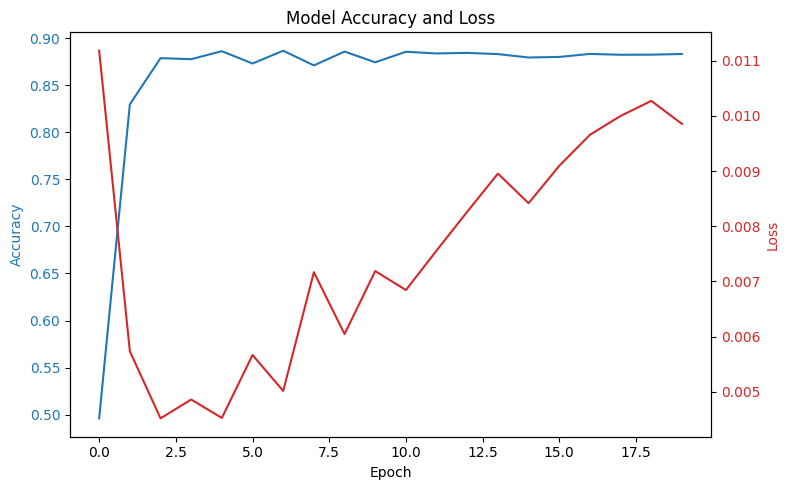

In [22]:
# Separate the accuracy and loss into individual lists
accuracy = [entry[0] for entry in model_history]
loss = [entry[1] for entry in model_history]

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot accuracy on the primary y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(accuracy, label='Accuracy', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis to plot the loss
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Loss', color='tab:red')  # we already handled the x-label with ax1
ax2.plot(loss, label='Loss', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and show the plot
plt.title('Model Accuracy and Loss')
fig.tight_layout()  # to make sure the right y-label is not slightly clipped
plt.show()